## Preamble

+ Run these lines of code first to import the necessary libraries and set up the plotting environment.

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

## How do inner products scale with system dimensionality?

+ As our test system, we consider the Lorenz-96 system. Given a vector $\mathbf{x} \in \mathbb{R}^{D}$, the dynamics are given by

$$
\dot{x}_i = (x_{i+1} - x_{i-2}) x_{i-1} - x_i + F
$$

where $i$ indexes the $D$ dynamical variables, and $F$ is a constant force term that controls the bifurcation to chaos. We assume that the variables are coupled together on a ring, and consider the case where $F = 8$. We will vary $D$ in order to examine the effect of dimensionality on the dynamics.

(-8.64900549214583, 13.080709536934034, -9.547737346574515, 15.287917008868487)

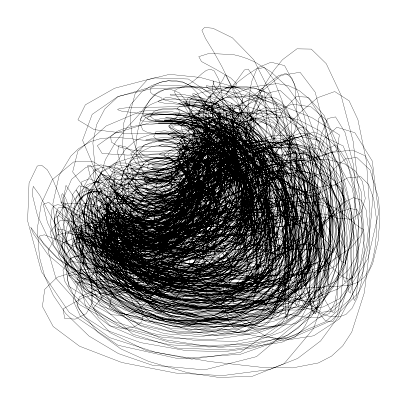

In [25]:
from scipy.integrate import solve_ivp


class Lorenz96:
    """
    Lorenz 96 model with constant forcing
    """

    def __init__(self, n=4, f=8.0):
        self.f = f
        self.n = n

    def rhs(self, t, X):

        Xdot = np.zeros_like(X)
        Xdot[2:-1] = (X[3:] - X[:-3]) * X[1:-2] - X[2:-1] + self.f
        Xdot[0] = (X[1] - X[-2]) * X[-1] - X[0] + self.f
        Xdot[1] = (X[2] - X[-1]) * X[0] - X[1] + self.f
        Xdot[-1] = (X[0] - X[-3]) * X[-2] - X[-1] + self.f

        return Xdot
    
    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)

eq = Lorenz96



nval = 15

eq = Lorenz96(n=nval)
ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
ic[0] += 0.01
# sol = solve_ivp(eq.rhs, [0, 30], ic, vectorized=True, max_step=0.01)
sol = solve_ivp(eq, (0, 500), ic, method="Radau")
ysol = sol.y.T
ysol = ysol[500:] # discard transient

plt.figure(figsize=(5, 5))
plt.plot(ysol[:, 0], ysol[:, 1], 'k', linewidth=0.2);
plt.axis("off")



+ We define a "spherized" two-point correlation function. Given two system states $\mathbf{x}(t), \mathbf{x}(t + \tau) \in \mathbb{R}^{D}$, we define the spherized inner product as

$$
g_2(\tau) = \langle \mathbf{x}(t), \mathbf{x}(t + \tau) \rangle_t = \frac{\mathbf{x}(t_1) \cdot \mathbf{x}(t_2)}{\|\mathbf{x}(t_1)\| \|\mathbf{x}(t_2)\|}
$$

This expression corresponds to the inner product between the unit vectors associated with the system states at times $t$ and $t + \tau$.

We also calculate the fluctuation of the inner product, which is defined as

$$
\sigma_2(\tau) = \sqrt{\langle g_2(\tau)^2 \rangle_t - \langle g_2(\tau) \rangle_t^2}
$$

Text(0, 0.5, 'Correlation Standard deviation')

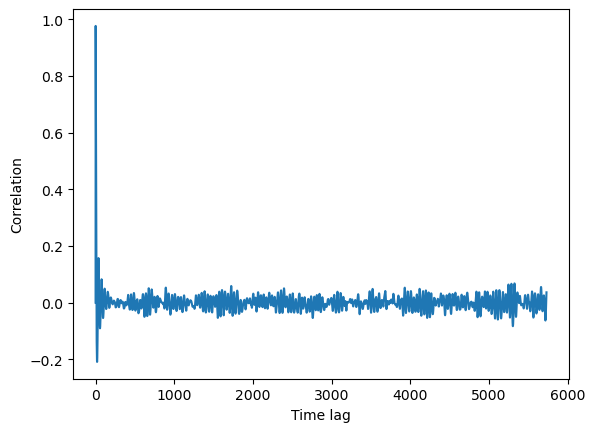

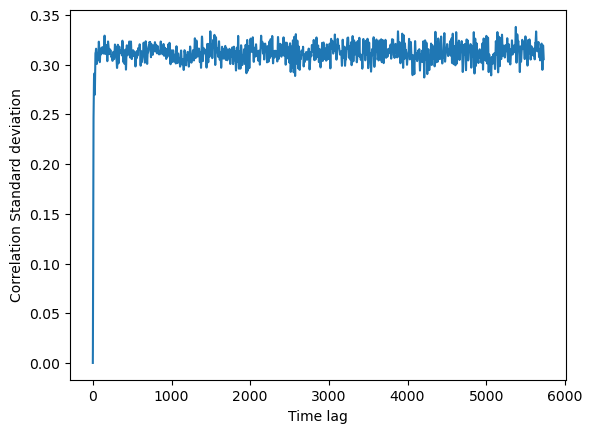

In [28]:
def twopoint_correlation(X, center=True, spherize=True):
    """
    Compute the instantaneous pairwise correlation between all pairs of timepoints

    Args:
        X (np.ndarray): shape (T, D)
        center (bool): If True, subtract the mean from each timepoint
        spherize (bool): If True, normalize each timepoint to a unit length vector
    """
    if center:
        X -= np.mean(X, axis=1, keepdims=True)
    if spherize:
        X /= np.linalg.norm(X, axis=1, keepdims=True)
    max_time = X.shape[0] // 2
    corrs = np.zeros(max_time)
    stds = np.zeros(max_time)
    for i in range(1, max_time):
        corrs[i] = np.mean(np.sum(X[i:] * X[:-i], axis=1))
        stds[i] = np.std(np.sum(X[i:] * X[:-i], axis=1))
    return corrs, stds

g2, g2_std = twopoint_correlation(ysol)

plt.figure()
plt.plot(g2)
plt.xlabel("Time lag")
plt.ylabel("Correlation")

plt.figure()
plt.plot(g2_std)
plt.xlabel("Time lag")
plt.ylabel("Correlation Standard deviation")

## How do the asymptotic correlations depend on dimensionality?

+ We loop over many values of $N$, simulate the system, and then record the two-point correlation function for each value of $N$.

+ As a point of comparison, we also record the two-point correlation function for randomly-sampled unit vectors of equal dimension to the trajectory vectors.


In [29]:


# nvals = np.arange(5, 300, 5)
nvals = np.arange(5, 100, 5)
# nvals = np.unique(5 * np.logspace(0, 3, 30)).astype(int)
all_corrs, all_corrs_std = [], []
all_corrs_gaussian, all_corrs_gaussian_std = [], []
for nval in nvals:
    print(f"Starting nval = {nval}")
    eq = Lorenz96(n=nval)
    ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
    ic[0] += 0.01
    sol = solve_ivp(eq, (0, 500), ic, method="Radau")
    ysol = sol.y.T
    ysol = ysol[500:] # discard transient

    g2, g2_std = twopoint_correlation(ysol)
    all_corrs.append(g2)
    all_corrs_std.append(g2_std)

    ## create equal-sized random Gaussian steps
    ysol_normal = np.random.normal(size=ysol.shape)

    g2, g2_std = twopoint_correlation(ysol_normal)
    all_corrs_gaussian.append(g2)
    all_corrs_gaussian_std.append(g2_std)





Starting nval = 5
Starting nval = 10
Starting nval = 15
Starting nval = 20
Starting nval = 25
Starting nval = 30
Starting nval = 35
Starting nval = 40
Starting nval = 45
Starting nval = 50
Starting nval = 55
Starting nval = 60
Starting nval = 65
Starting nval = 70
Starting nval = 75
Starting nval = 80
Starting nval = 85
Starting nval = 90
Starting nval = 95


## We fit a power law in the large-$N$ limit

+ We consider only the asymptotic behavior of the correlation function (large-$\tau$), and fit a power law to the standard deviation of this asymptote in the large-$N$ limit.

Best fit prefactor = 1.23, exponent = -0.51


Text(0, 0.5, 'Asymptotic Standard deviation of pairwise correlations')

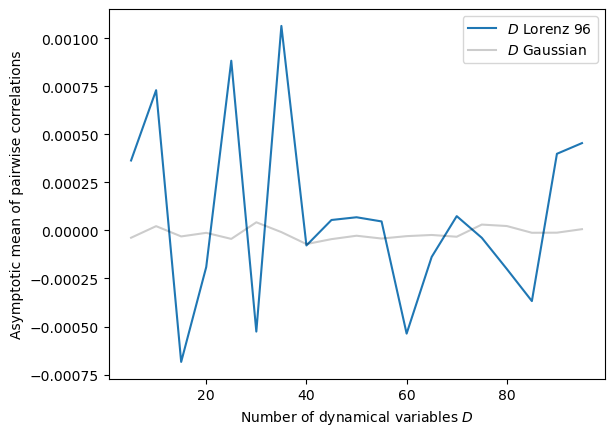

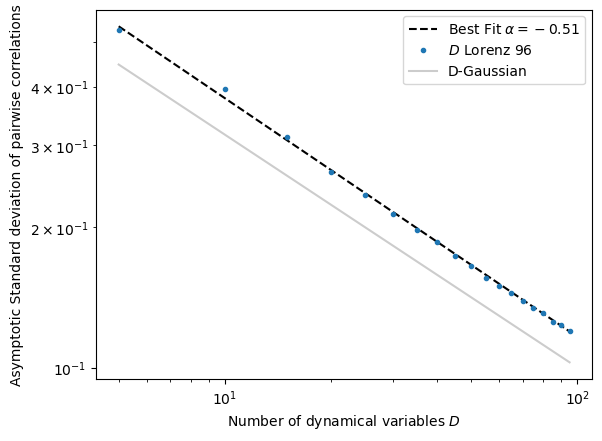

In [45]:



mean_asymp = [np.mean(corr[-3000:]) for corr in all_corrs]
std_asymp = [np.mean(corr_std[-3000:]) for corr_std in all_corrs_std]

mean_asymp_gaussian = [np.mean(corr[-3000:]) for corr in all_corrs_gaussian]
std_asymp_gaussian = [np.mean(corr_std[-3000:]) for corr_std in all_corrs_gaussian_std]

plt.figure()
plt.plot(nvals, mean_asymp, label="$D$ Lorenz 96")
plt.plot(nvals, mean_asymp_gaussian, color=(0.0, 0.0, 0.0, 0.2), label="$D$ Gaussian")
plt.xlabel("Number of dynamical variables $D$")
plt.ylabel("Asymptotic mean of pairwise correlations")
plt.legend()



# Fit custom power law
from scipy.optimize import curve_fit
power_law = lambda x, a, b:  a * x**b
popt, pcov = curve_fit(power_law, nvals[-20:], std_asymp[-20:])
print(f"Best fit prefactor = {popt[0]:.2f}, exponent = {popt[1]:.2f}")
plt.figure()
plt.plot(nvals, power_law(nvals, *popt), '--k', label=f"Best Fit $\\alpha = {popt[1]:.2f}$")

# invsq_law = lambda x, a:  a * x**(-0.5)
# popt, pcov = curve_fit(invsq_law, nvals[-20:], std_asymp[-20:])
# plt.plot(nvals, invsq_law(nvals, *popt), '--r', label=f"$\\alpha = -1/2$")
# print(f"Equivalent Normal is {1/np.sqrt(popt[0])} times the number of dynamical variables $D$")

## Inverse linear law as check
# invlin_law = lambda x, a:  a * x**(-1.0)
# popt, pcov = curve_fit(invlin_law, nvals[-20:], std_asymp[-20:])
# plt.plot(nvals, invlin_law(nvals, *popt), '--b', label=f"$\\alpha = -1$")



plt.loglog(nvals, std_asymp, '.', label="$D$ Lorenz 96")
# plt.loglog(nvals, std_asymp_gaussian,  color=(0.0, 0.0, 0.0, 0.2), label="$D$ Gaussian")
plt.loglog(nvals, 1 / np.sqrt(nvals), color=(0.0, 0.0, 0.0, 0.2), label="D-Gaussian")

plt.legend()
plt.xlabel("Number of dynamical variables $D$")
plt.ylabel("Asymptotic Standard deviation of pairwise correlations")




### Finding the "effective dimensionality" of the system

+ For unit vectors uniformly sampled from the surface of a unit hypersphere, the asymptotic correlation function should exhibit fluctuations around zero exactly equal to $D^{-1/2}$. Randomly sampling Gaussian vectors and then normalizing them to unit length should be an unbiased sampler of the surface of the unit hypersphere.

+ However, the asymptotic correlation function for the Lorenz-96 system exhibits fluctuations around zero that go as $A\, D^{-1/2}$, where the prefactor $A > 1.0$ is a constant.

+ We can use this prefactor to determine the "effective dimensionality" of the dynamics of a $D$ dimensional Lorenz-96 system. We can define the effective dimensionality as

$$
D_{\text{eff}} = \sqrt{\frac{D_{dim}}{A}}
$$




In [47]:
print(f"Equivalent Normal dimension is {1/np.sqrt(popt[0])} times the number of dynamical Lorenz variables $D$")

Equivalent Normal dimension is 0.9008922540715618 times the number of dynamical Lorenz variables $D$


### Other notions of dimensionality to compare against

+ [Grassberger-Procaccia correlation dimension:](http://www.scholarpedia.org/article/Grassberger-Procaccia_algorithm) very similar, but small-$\epsilon$ scaling limit of nearest neighbor count
+ + Probably should use Clauset et al. power law estimator for this

+ [PCA dimension](https://www.biorxiv.org/content/10.1101/2020.12.19.423618v3.full.pdf): participation ratio of eigenvalue spectrum

#### Useful links:

[Stackexchange](https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions) summarizing [Baravinok's notes](https://dept.math.lsa.umich.edu/~barvinok/total710.pdf)
